## Baseline Model

### Disclaimer: 

This notebook includes text generated by a large language model (LLM). While I have reviewed and edited the content to the best of my ability, it is important to acknowledge the potential for inaccuracies. I encourage you to cross-check any critical information with independent sources.

### Author: 
Yimeng He (Yimeng.He@cshs.org)


### Encoder-Decoder Model for Image Segmentation

The encoder-decoder architecture is a popular approach for image segmentation tasks. It consists of two main components:

1. **Encoder**: Responsible for capturing and encoding relevant features from the input image. Typically composed of convolutional and pooling layers that progressively reduce spatial dimensions.

2. **Decoder**: Responsible for generating the segmentation mask from the encoded features. Consists of upsampling/transposed convolutional layers that increase spatial dimensions. Often utilizes skip connections from the encoder to incorporate low-level spatial details.

This architecture allows the model to capture both high-level semantic information (from the encoder) and low-level spatial details (from the decoder skip connections), enabling accurate segmentation.

### Download Data

In [7]:
import os

# Define the file path and extracted directory path
file_path = 'images.zip'
extracted_path = 'lgg-mri-segmentation/kaggle_3m'

# Check if the file already exists
if not os.path.exists(file_path):
    # Download the file if it doesn't exist
    !wget --no-check-certificate 'https://drive.usercontent.google.com/download?id=1cfORNOh_p1KHbhw8U0zhGkjSC2IrGaTB&export=download&confirm=t&uuid=c5760839-02fd-436b-9e38-9635cd7d8aab&at=APZUnTVLTsvNxsW4SInOAOYrK9ZA%3A1715907782351' -O images.zip
else:
    print("File already exists. No need to download again.")

# Check if the directory already exists
if not os.path.exists(extracted_path):
    # Unzip the file if the directory doesn't exist
    !unzip -n images.zip -d lgg-mri-segmentation
    print("Unzip operation completed.")
else:
    print("Files are already extracted. No need to unzip again.")

# IMAGE_PATH variable
IMAGE_PATH = 'lgg-mri-segmentation/kaggle_3m'

# Your existing code for listing the paths
paths = []
for dirname in os.listdir(IMAGE_PATH):
    if os.path.isdir(os.path.join(IMAGE_PATH, dirname)):
        for filename in os.listdir(os.path.join(IMAGE_PATH, dirname)):
            # Only the files with ',tif' format should be added to the 'paths' list
            if filename.endswith('.tif'):
                paths.append(IMAGE_PATH+'/'+dirname+'/'+filename)

len(paths), paths[:20:5]


File already exists. No need to download again.
Files are already extracted. No need to unzip again.


(7858,
 ['lgg-mri-segmentation/kaggle_3m/TCGA_DU_8164_19970111/TCGA_DU_8164_19970111_4_mask.tif',
  'lgg-mri-segmentation/kaggle_3m/TCGA_DU_8164_19970111/TCGA_DU_8164_19970111_9_mask.tif',
  'lgg-mri-segmentation/kaggle_3m/TCGA_DU_8164_19970111/TCGA_DU_8164_19970111_4.tif',
  'lgg-mri-segmentation/kaggle_3m/TCGA_DU_8164_19970111/TCGA_DU_8164_19970111_27.tif'])

### Data Preprocessing

In [8]:
## source https://www.kaggle.com/code/saeedghamshadzai/image-segmentation-brain-tumor-u-net-cnn#Inferece
from PIL import Image
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
def data_frame(data):
    # Storing only paths that don't end with 'mask.tiff'
    images = list(filter(lambda x: not x.endswith('mask.tif'), data))
    # Sorting images based on the number of each MRI.
    images.sort(key=lambda x: int(x.rsplit('_', 3)[-1][:-4]))
    # Sorting by the patient IDs (each patient has more than 1 MRIs)
    images.sort(key=lambda x: int(x.rsplit('_', 3)[-2]))

    # Storing the image IDs
    IDs = list(map(lambda x: x.rsplit('/', 3)[-1][:-4], images))

    # Storing only paths that end with 'mask.tiff'
    masks = list(filter(lambda x: x.endswith('mask.tif'), data))
    # Sorting masks based on the number of each MRI.
    masks.sort(key=lambda x: int(x.rsplit('_', 3)[-2]))
    # Sorting by the patient IDs (each patient has more than 1 MRIs)
    masks.sort(key=lambda x: int(x.rsplit('_', 3)[-3]))

    # Opens the images
    pixels = lambda x: Image.open(x)
    # Selects the largest pixel
    largest_pixel = lambda y: np.max(pixels(y))
    # Determines if the mask contains an abnormality or not (+ or -)
    # Remember that a negative image's mask is just an entirely black image.
    diagnotic_function = lambda z: 1 if largest_pixel(z) > 0 else 0
    # Storing the diagnosis corresponding to each image
    diagnoses = list(map(lambda x: diagnotic_function(x), masks))

    # Making the dataframe
    DataFrame = pd.DataFrame({'ID': IDs, 'Image': images, 'Mask': masks, 'Diagnosis': diagnoses})

    # Dividing the indexes into train, test, and validation
    train_index, test_index = train_test_split(DataFrame.index.values.tolist(), test_size=0.15, random_state=42)
    train_index, val_index = train_test_split(train_index, test_size=0.1, random_state=42)

    # Making train, test, and validation dataframes
    train_df, val_df, test_df = DataFrame.iloc[train_index], DataFrame.iloc[val_index], DataFrame.iloc[test_index]

    return train_df, val_df, test_df

# Making the dataframes
train_df, val_df, test_df = data_frame(paths)

print(len(train_df), len(val_df), len(test_df))

train_df.head()

3005 334 590


,ID,Image,Mask,Diagnosis
472,TCGA_DU_6408_19860521_31,lgg-mri-segmentation/kaggle_3m/TCGA_DU_6408_19...,lgg-mri-segmentation/kaggle_3m/TCGA_DU_6408_19...,1
288,TCGA_DU_6405_19851005_23,lgg-mri-segmentation/kaggle_3m/TCGA_DU_6405_19...,lgg-mri-segmentation/kaggle_3m/TCGA_DU_6405_19...,0
3666,TCGA_FG_6691_20020405_29,lgg-mri-segmentation/kaggle_3m/TCGA_FG_6691_20...,lgg-mri-segmentation/kaggle_3m/TCGA_FG_6691_20...,1
851,TCGA_DU_7018_19911220_36,lgg-mri-segmentation/kaggle_3m/TCGA_DU_7018_19...,lgg-mri-segmentation/kaggle_3m/TCGA_DU_7018_19...,0
2796,TCGA_HT_A61B_19991127_11,lgg-mri-segmentation/kaggle_3m/TCGA_HT_A61B_19...,lgg-mri-segmentation/kaggle_3m/TCGA_HT_A61B_19...,0


### Visualizing

In [9]:
from PIL import Image
import matplotlib.pyplot as plt

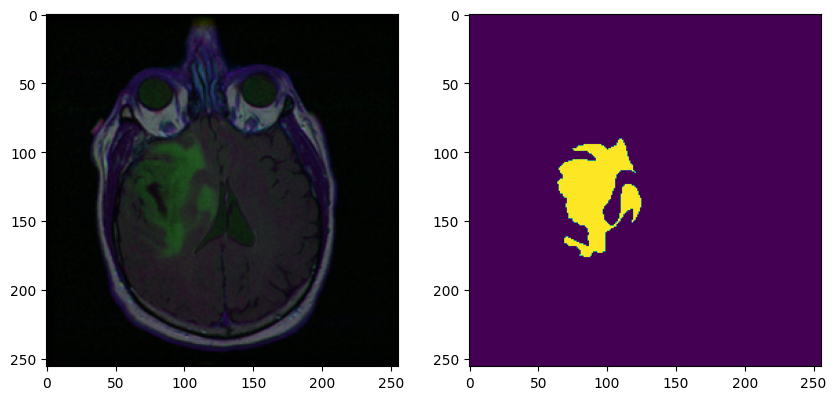

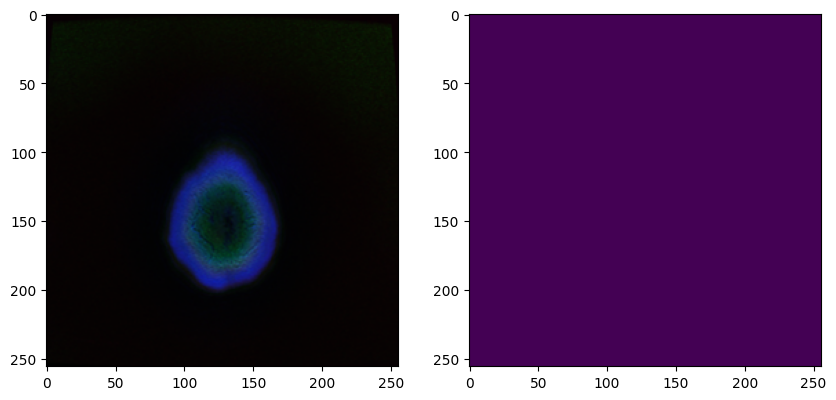

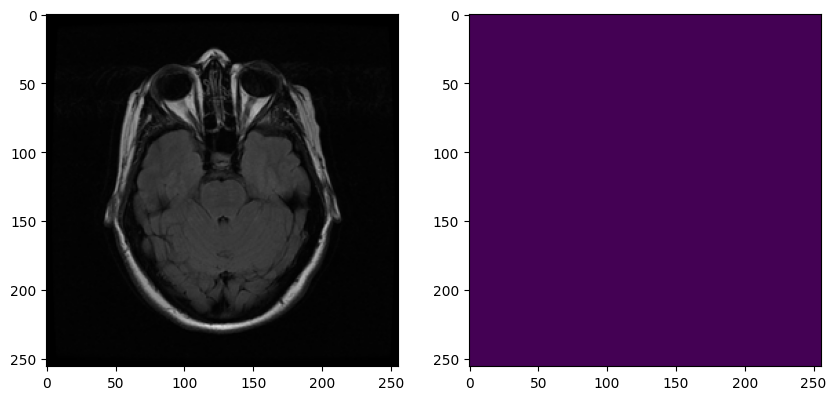

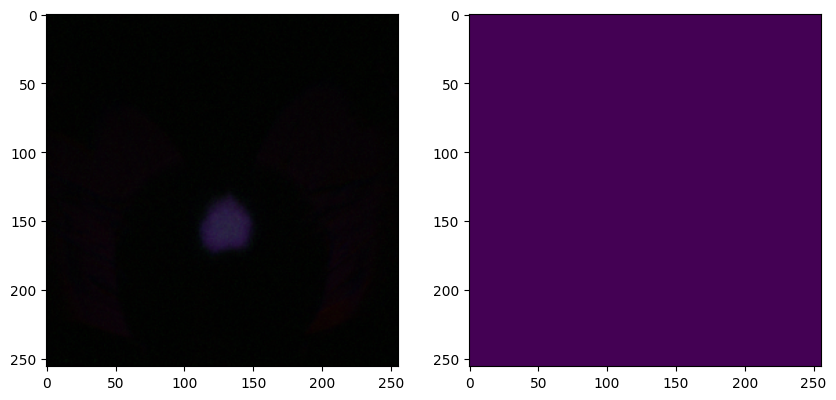

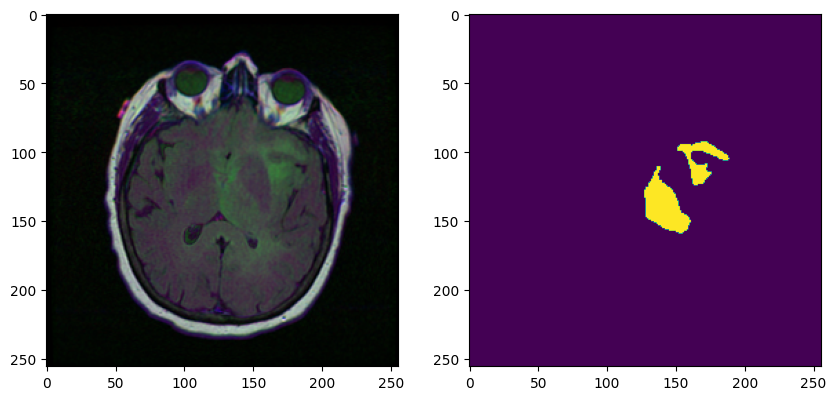

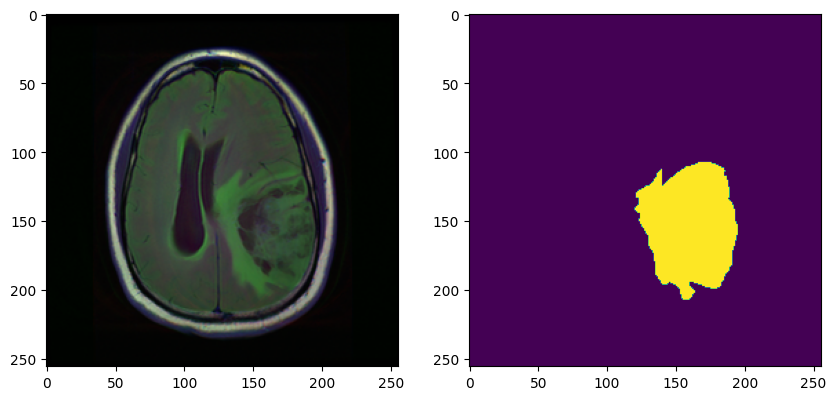

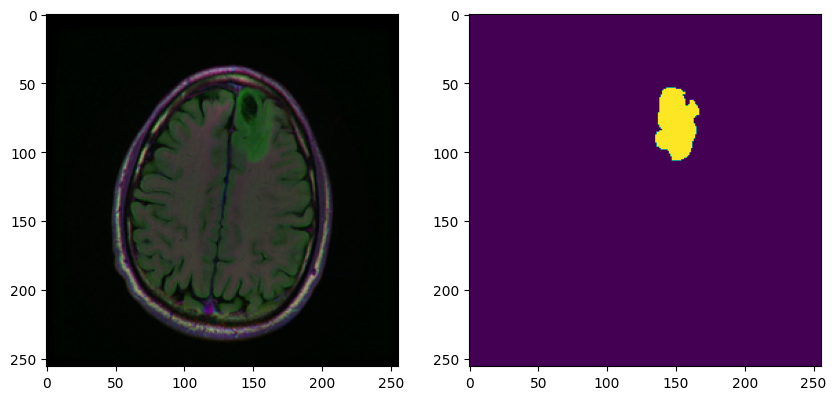

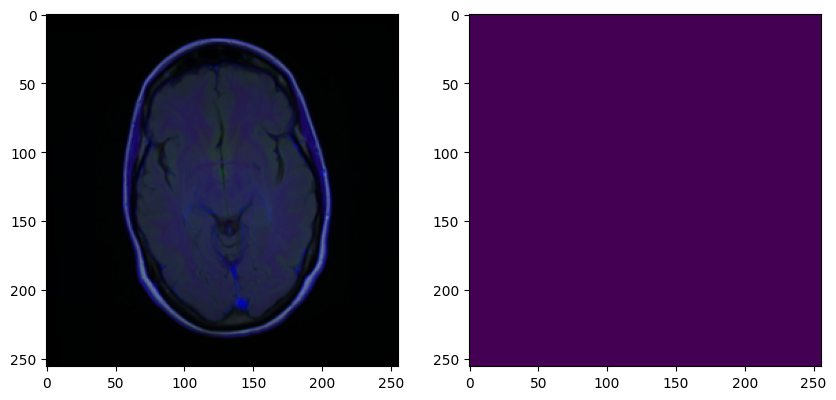

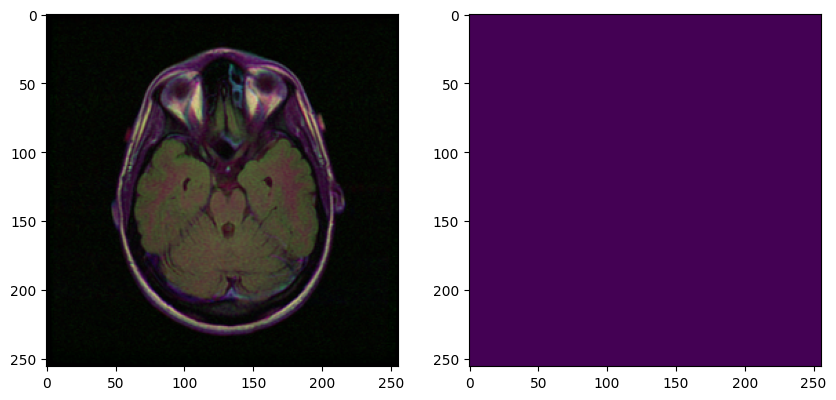

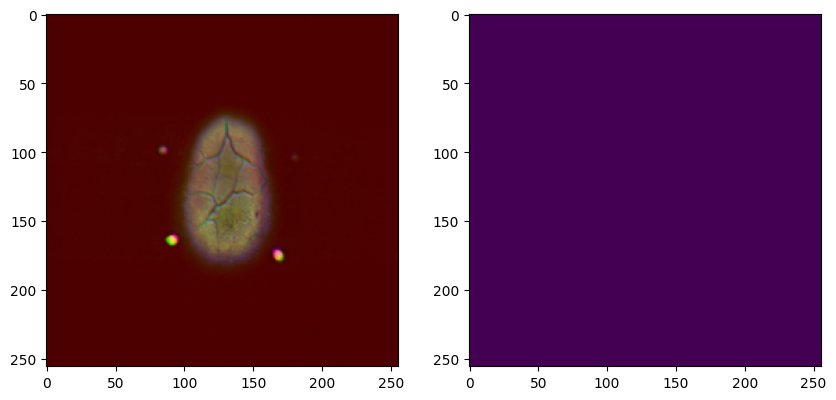

In [10]:
index = np.arange(train_df.shape[0])
rng = np.random.default_rng(37)
rng.shuffle(index)
for idx in range(10):
    image_path = train_df.iloc[index[idx]]['Image']
    mask_path = train_df.iloc[index[idx]]['Mask']
    image = Image.open(image_path).convert('RGB')
    mask = Image.open(mask_path).convert('L')
    fig, ax = plt.subplots(1, 2, figsize=(10, 5))
    ax[0].imshow(image)
    ax[1].imshow(mask)

### Training the Model

Encoder and Decoder model with BCELoss

In [11]:
import torch.optim as optim
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn

class EncoderDecoder(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(EncoderDecoder, self).__init__()

        # Encoder
        self.encoder = nn.Sequential(
            nn.Conv2d(in_channels, 64, 3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, 2),  # 128 x 128 x 64
            nn.Conv2d(64, 128, 3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, 2),  # 64 x 64 x 128
            nn.Conv2d(128, 256, 3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, 2)  # 32 x 32 x 256
        )

        # Decoder
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(256, 128, 3, stride=2, padding=1, output_padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(128, 64, 3, stride=2, padding=1, output_padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(64, out_channels, 3, stride=2, padding=1, output_padding=1),
            nn.Sigmoid()
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

# Check available CUDA devices
if torch.cuda.is_available():
    print(f"Number of available GPUs: {torch.cuda.device_count()}")
    for i in range(torch.cuda.device_count()):
        print(f"CUDA device {i}: {torch.cuda.get_device_name(i)}")

# Update device assignment
device = torch.device(0 if torch.cuda.is_available() else 'cpu')
# Initialize the model
model = EncoderDecoder(3, 1).float().to(device)



Number of available GPUs: 1
CUDA device 0: Tesla P100-PCIE-16GB


In [12]:
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
class SegmentationDataset(Dataset):
    def __init__(self, image_paths, mask_paths, transform=None):
        self.image_paths = image_paths
        self.mask_paths = mask_paths
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img = Image.open(self.image_paths[idx]).convert('RGB')
        mask = Image.open(self.mask_paths[idx]).convert('L')

        img = np.array(img)
        mask = np.array(mask)
        if self.transform:
            img = self.transform(img)
            mask = self.transform(mask)
        return img, mask


# Transform
transform = transforms.Compose([
    transforms.Lambda(lambda x: x/255.0),
    transforms.ToTensor()
])



  0%|          | 0/500 [00:00<?, ?it/s]

Epoch 1/500, Loss: 0.3472



  0%|          | 1/500 [00:27<3:47:23, 27.34s/it]

Dev Loss: 0.1729
Epoch 2/500, Loss: 0.0381



  0%|          | 2/500 [00:53<3:38:58, 26.38s/it]

Dev Loss: 0.0319
Epoch 3/500, Loss: 0.0270



  1%|          | 3/500 [01:18<3:35:06, 25.97s/it]

Dev Loss: 0.0288
Epoch 4/500, Loss: 0.0259



  1%|          | 4/500 [01:43<3:31:30, 25.59s/it]

Dev Loss: 0.0283
Epoch 5/500, Loss: 0.0245



  1%|          | 5/500 [02:08<3:30:06, 25.47s/it]

Dev Loss: 0.0284
Epoch 6/500, Loss: 0.0243



  1%|          | 6/500 [02:34<3:29:14, 25.41s/it]

Dev Loss: 0.0267
Epoch 7/500, Loss: 0.0236



  1%|▏         | 7/500 [02:59<3:28:13, 25.34s/it]

Dev Loss: 0.0259
Epoch 8/500, Loss: 0.0227



  2%|▏         | 8/500 [03:24<3:27:22, 25.29s/it]

Dev Loss: 0.0257
Epoch 9/500, Loss: 0.0216



  2%|▏         | 9/500 [03:49<3:27:04, 25.30s/it]

Dev Loss: 0.0242
Epoch 10/500, Loss: 0.0216



  2%|▏         | 10/500 [04:15<3:27:30, 25.41s/it]

Dev Loss: 0.0231
Epoch 11/500, Loss: 0.0216



  2%|▏         | 11/500 [04:40<3:26:07, 25.29s/it]

Dev Loss: 0.0227
Epoch 12/500, Loss: 0.0201



  2%|▏         | 12/500 [05:05<3:24:25, 25.13s/it]

Dev Loss: 0.0227
Epoch 13/500, Loss: 0.0197



  3%|▎         | 13/500 [05:30<3:23:42, 25.10s/it]

Dev Loss: 0.0224
Epoch 14/500, Loss: 0.0195



  3%|▎         | 14/500 [05:55<3:22:46, 25.03s/it]

Dev Loss: 0.0204
Epoch 15/500, Loss: 0.0185



  3%|▎         | 15/500 [06:20<3:23:02, 25.12s/it]

Dev Loss: 0.0195
Epoch 16/500, Loss: 0.0181



  3%|▎         | 16/500 [06:45<3:22:19, 25.08s/it]

Dev Loss: 0.0199
Epoch 17/500, Loss: 0.0182



  3%|▎         | 17/500 [07:10<3:21:02, 24.97s/it]

Dev Loss: 0.0195
Epoch 18/500, Loss: 0.0176



  4%|▎         | 18/500 [07:35<3:21:01, 25.02s/it]

Dev Loss: 0.0192
Epoch 19/500, Loss: 0.0170



  4%|▍         | 19/500 [08:00<3:21:05, 25.08s/it]

Dev Loss: 0.0188
Epoch 20/500, Loss: 0.0173



  4%|▍         | 20/500 [08:25<3:21:12, 25.15s/it]

Dev Loss: 0.0183
Epoch 21/500, Loss: 0.0160



  4%|▍         | 21/500 [08:50<3:20:43, 25.14s/it]

Dev Loss: 0.0180
Epoch 22/500, Loss: 0.0158



  4%|▍         | 22/500 [09:16<3:20:05, 25.12s/it]

Dev Loss: 0.0181
Epoch 23/500, Loss: 0.0154



  5%|▍         | 23/500 [09:41<3:20:34, 25.23s/it]

Dev Loss: 0.0162
Epoch 24/500, Loss: 0.0146



  5%|▍         | 24/500 [10:07<3:20:46, 25.31s/it]

Dev Loss: 0.0183
Epoch 25/500, Loss: 0.0145



  5%|▌         | 25/500 [10:32<3:20:26, 25.32s/it]

Dev Loss: 0.0160
Epoch 26/500, Loss: 0.0144



  5%|▌         | 26/500 [10:57<3:19:28, 25.25s/it]

Dev Loss: 0.0160
Epoch 27/500, Loss: 0.0145



  5%|▌         | 27/500 [11:22<3:18:02, 25.12s/it]

Dev Loss: 0.0153
Epoch 28/500, Loss: 0.0135



  6%|▌         | 28/500 [11:47<3:17:51, 25.15s/it]

Dev Loss: 0.0154
Epoch 29/500, Loss: 0.0140



  6%|▌         | 29/500 [12:12<3:17:07, 25.11s/it]

Dev Loss: 0.0143
Epoch 30/500, Loss: 0.0130



  6%|▌         | 30/500 [12:37<3:16:59, 25.15s/it]

Dev Loss: 0.0141
Epoch 31/500, Loss: 0.0125



  6%|▌         | 31/500 [13:02<3:16:11, 25.10s/it]

Dev Loss: 0.0146
Epoch 32/500, Loss: 0.0128



  6%|▋         | 32/500 [13:27<3:15:31, 25.07s/it]

Dev Loss: 0.0148
Epoch 33/500, Loss: 0.0119



  7%|▋         | 33/500 [13:52<3:15:07, 25.07s/it]

Dev Loss: 0.0139
Epoch 34/500, Loss: 0.0116



  7%|▋         | 34/500 [14:17<3:14:57, 25.10s/it]

Dev Loss: 0.0137
Epoch 35/500, Loss: 0.0115



  7%|▋         | 35/500 [14:43<3:15:38, 25.24s/it]

Dev Loss: 0.0135
Epoch 36/500, Loss: 0.0112



  7%|▋         | 36/500 [15:07<3:12:31, 24.90s/it]

Dev Loss: 0.0138
Epoch 37/500, Loss: 0.0115



  7%|▋         | 37/500 [15:32<3:12:36, 24.96s/it]

Dev Loss: 0.0147
Epoch 38/500, Loss: 0.0110



  8%|▊         | 38/500 [15:57<3:12:31, 25.00s/it]

Dev Loss: 0.0133
Epoch 39/500, Loss: 0.0107



  8%|▊         | 39/500 [16:23<3:12:34, 25.06s/it]

Dev Loss: 0.0135
Epoch 40/500, Loss: 0.0104



  8%|▊         | 40/500 [16:48<3:12:14, 25.07s/it]

Dev Loss: 0.0128
Epoch 41/500, Loss: 0.0100



  8%|▊         | 41/500 [17:13<3:11:47, 25.07s/it]

Dev Loss: 0.0121
Epoch 42/500, Loss: 0.0102



  8%|▊         | 42/500 [17:38<3:12:20, 25.20s/it]

Dev Loss: 0.0135
Epoch 43/500, Loss: 0.0106



  9%|▊         | 43/500 [18:03<3:11:57, 25.20s/it]

Dev Loss: 0.0122
Epoch 44/500, Loss: 0.0095



  9%|▉         | 44/500 [18:29<3:12:10, 25.29s/it]

Dev Loss: 0.0127
Epoch 45/500, Loss: 0.0093



  9%|▉         | 45/500 [18:54<3:11:49, 25.30s/it]

Dev Loss: 0.0119
Epoch 46/500, Loss: 0.0089



  9%|▉         | 46/500 [19:19<3:10:58, 25.24s/it]

Dev Loss: 0.0118
Epoch 47/500, Loss: 0.0090



  9%|▉         | 47/500 [19:45<3:11:03, 25.31s/it]

Dev Loss: 0.0119
Epoch 48/500, Loss: 0.0093



 10%|▉         | 48/500 [20:10<3:10:48, 25.33s/it]

Dev Loss: 0.0126
Epoch 49/500, Loss: 0.0089



 10%|▉         | 49/500 [20:35<3:10:19, 25.32s/it]

Dev Loss: 0.0114
Epoch 50/500, Loss: 0.0083



 10%|█         | 50/500 [21:00<3:08:50, 25.18s/it]

Dev Loss: 0.0111
Epoch 51/500, Loss: 0.0079



 10%|█         | 51/500 [21:25<3:08:02, 25.13s/it]

Dev Loss: 0.0113
Epoch 52/500, Loss: 0.0082



 10%|█         | 52/500 [21:50<3:07:18, 25.09s/it]

Dev Loss: 0.0105
Epoch 53/500, Loss: 0.0076



 11%|█         | 53/500 [22:16<3:07:28, 25.16s/it]

Dev Loss: 0.0111
Epoch 54/500, Loss: 0.0075



 11%|█         | 54/500 [22:41<3:07:13, 25.19s/it]

Dev Loss: 0.0108
Epoch 55/500, Loss: 0.0078



 11%|█         | 55/500 [23:06<3:07:07, 25.23s/it]

Dev Loss: 0.0121
Epoch 56/500, Loss: 0.0074



 11%|█         | 56/500 [23:32<3:06:50, 25.25s/it]

Dev Loss: 0.0104
Epoch 57/500, Loss: 0.0071



 11%|█▏        | 57/500 [23:57<3:06:28, 25.26s/it]

Dev Loss: 0.0107
Epoch 58/500, Loss: 0.0070



 12%|█▏        | 58/500 [24:22<3:06:28, 25.31s/it]

Dev Loss: 0.0112
Epoch 59/500, Loss: 0.0074



 12%|█▏        | 59/500 [24:47<3:05:25, 25.23s/it]

Dev Loss: 0.0124
Epoch 60/500, Loss: 0.0071



 12%|█▏        | 60/500 [25:12<3:04:20, 25.14s/it]

Dev Loss: 0.0111
Epoch 61/500, Loss: 0.0068



 12%|█▏        | 61/500 [25:37<3:03:51, 25.13s/it]

Dev Loss: 0.0106
Epoch 62/500, Loss: 0.0066



 12%|█▏        | 62/500 [26:02<3:02:49, 25.04s/it]

Dev Loss: 0.0109
Epoch 63/500, Loss: 0.0064



 13%|█▎        | 63/500 [26:27<3:02:15, 25.02s/it]

Dev Loss: 0.0103
Epoch 64/500, Loss: 0.0064



 13%|█▎        | 64/500 [26:52<3:01:36, 24.99s/it]

Dev Loss: 0.0106
Epoch 65/500, Loss: 0.0067



 13%|█▎        | 65/500 [27:17<3:01:53, 25.09s/it]

Dev Loss: 0.0111
Epoch 66/500, Loss: 0.0060



 13%|█▎        | 66/500 [27:43<3:02:00, 25.16s/it]

Dev Loss: 0.0106
Epoch 67/500, Loss: 0.0057



 13%|█▎        | 67/500 [28:08<3:01:54, 25.21s/it]

Dev Loss: 0.0104
Epoch 68/500, Loss: 0.0058



 14%|█▎        | 68/500 [28:33<3:01:40, 25.23s/it]

Dev Loss: 0.0107
Epoch 69/500, Loss: 0.0058



 14%|█▍        | 69/500 [28:59<3:01:37, 25.28s/it]

Dev Loss: 0.0115
Epoch 70/500, Loss: 0.0053



 14%|█▍        | 70/500 [29:24<3:01:28, 25.32s/it]

Dev Loss: 0.0104
Epoch 71/500, Loss: 0.0053



 14%|█▍        | 71/500 [29:49<3:01:07, 25.33s/it]

Dev Loss: 0.0099
Epoch 72/500, Loss: 0.0050



 14%|█▍        | 72/500 [30:15<3:00:42, 25.33s/it]

Dev Loss: 0.0106
Epoch 73/500, Loss: 0.0050



 15%|█▍        | 73/500 [30:40<2:59:37, 25.24s/it]

Dev Loss: 0.0111
Epoch 74/500, Loss: 0.0060



 15%|█▍        | 74/500 [31:03<2:54:16, 24.55s/it]

Dev Loss: 0.0131
Epoch 75/500, Loss: 0.0053



 15%|█▌        | 75/500 [31:28<2:54:55, 24.70s/it]

Dev Loss: 0.0102
Epoch 76/500, Loss: 0.0047



 15%|█▌        | 76/500 [31:53<2:55:52, 24.89s/it]

Dev Loss: 0.0112
Epoch 77/500, Loss: 0.0046



 15%|█▌        | 77/500 [32:18<2:56:05, 24.98s/it]

Dev Loss: 0.0098
Epoch 78/500, Loss: 0.0045



 16%|█▌        | 78/500 [32:44<2:56:23, 25.08s/it]

Dev Loss: 0.0113
Epoch 79/500, Loss: 0.0047



 16%|█▌        | 79/500 [33:09<2:56:33, 25.16s/it]

Dev Loss: 0.0112
Epoch 80/500, Loss: 0.0046



 16%|█▌        | 80/500 [33:34<2:55:14, 25.03s/it]

Dev Loss: 0.0123
Epoch 81/500, Loss: 0.0048



 16%|█▌        | 81/500 [33:59<2:54:58, 25.06s/it]

Dev Loss: 0.0105
Epoch 82/500, Loss: 0.0045



 16%|█▋        | 82/500 [34:24<2:55:08, 25.14s/it]

Dev Loss: 0.0108
Epoch 83/500, Loss: 0.0044



 17%|█▋        | 83/500 [34:50<2:55:24, 25.24s/it]

Dev Loss: 0.0139
Epoch 84/500, Loss: 0.0053



 17%|█▋        | 84/500 [35:15<2:55:25, 25.30s/it]

Dev Loss: 0.0116
Epoch 85/500, Loss: 0.0058



 17%|█▋        | 85/500 [35:40<2:54:52, 25.28s/it]

Dev Loss: 0.0104
Epoch 86/500, Loss: 0.0040



 17%|█▋        | 86/500 [36:05<2:54:11, 25.25s/it]

Dev Loss: 0.0108
Epoch 87/500, Loss: 0.0038



 17%|█▋        | 87/500 [36:31<2:53:51, 25.26s/it]

Dev Loss: 0.0105
Epoch 88/500, Loss: 0.0041



 18%|█▊        | 88/500 [36:56<2:52:36, 25.14s/it]

Dev Loss: 0.0109
Epoch 89/500, Loss: 0.0038



 18%|█▊        | 89/500 [37:20<2:51:18, 25.01s/it]

Dev Loss: 0.0109
Epoch 90/500, Loss: 0.0035



 18%|█▊        | 90/500 [37:45<2:50:08, 24.90s/it]

Dev Loss: 0.0117
Epoch 91/500, Loss: 0.0036



 18%|█▊        | 91/500 [38:10<2:49:49, 24.91s/it]

Dev Loss: 0.0118
Epoch 92/500, Loss: 0.0034



 18%|█▊        | 91/500 [38:35<2:53:26, 25.44s/it]


Dev Loss: 0.0112
Early stopping after 92 epochs.


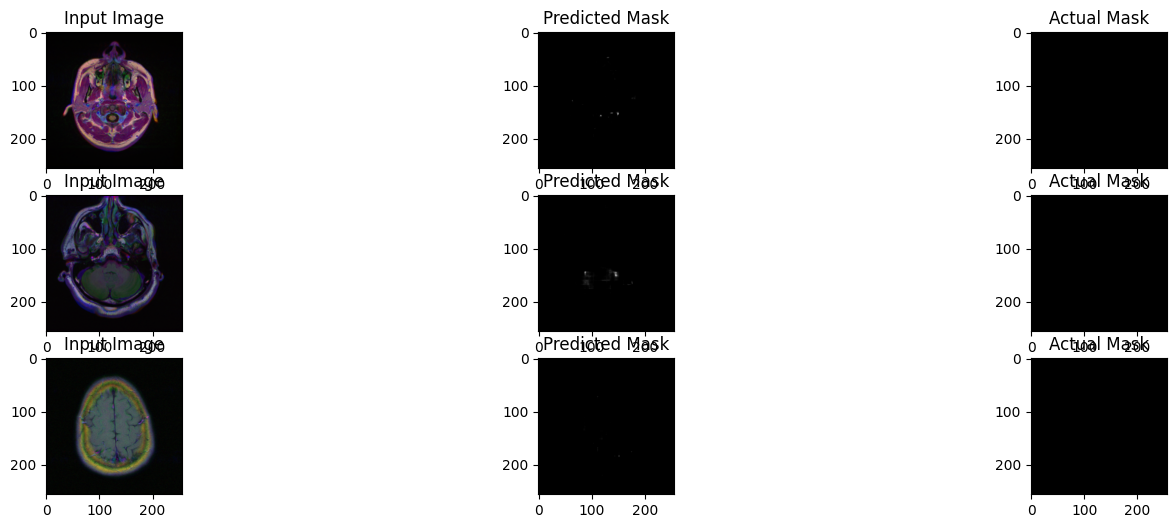

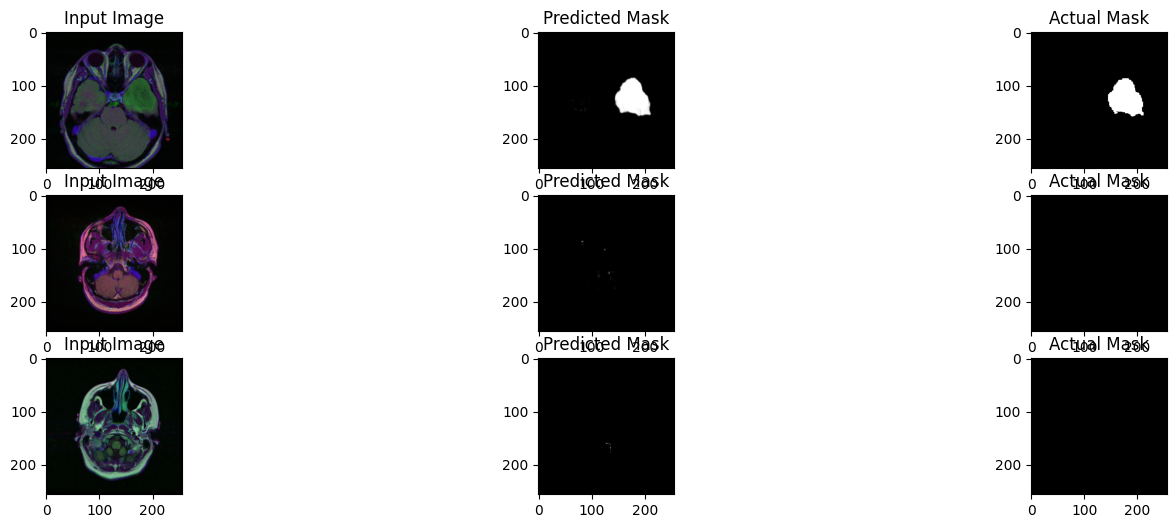

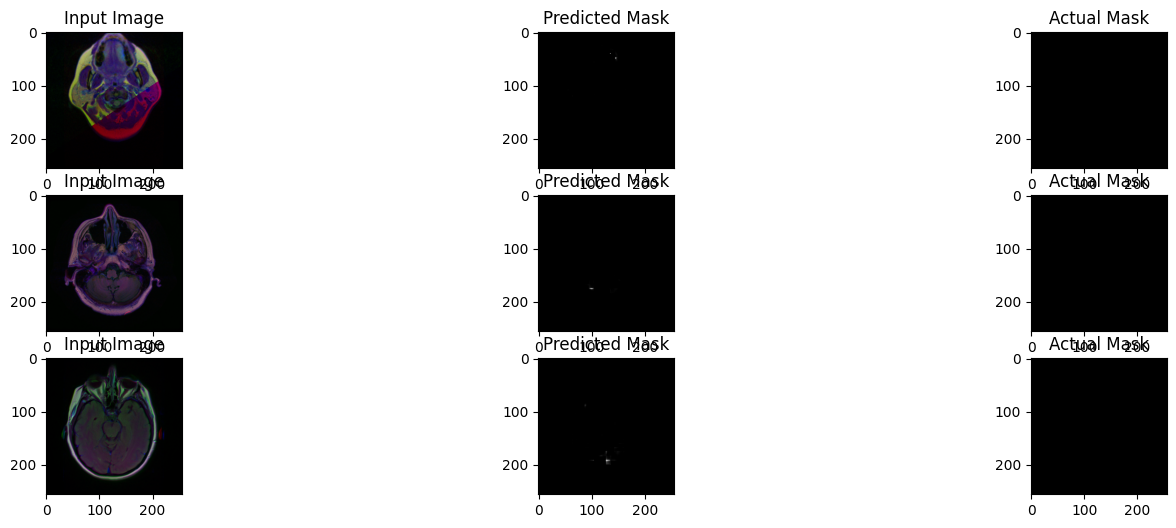

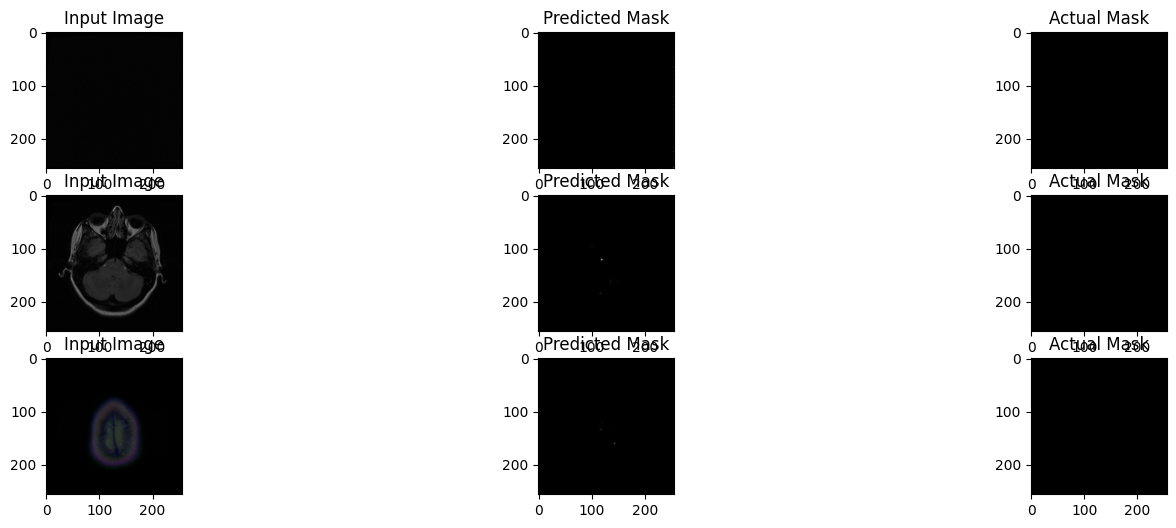

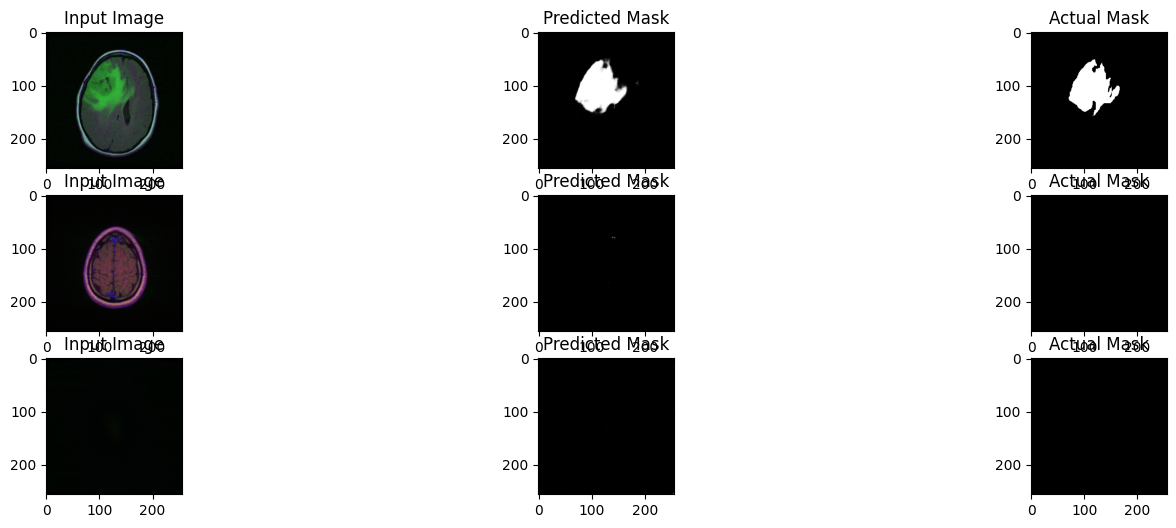

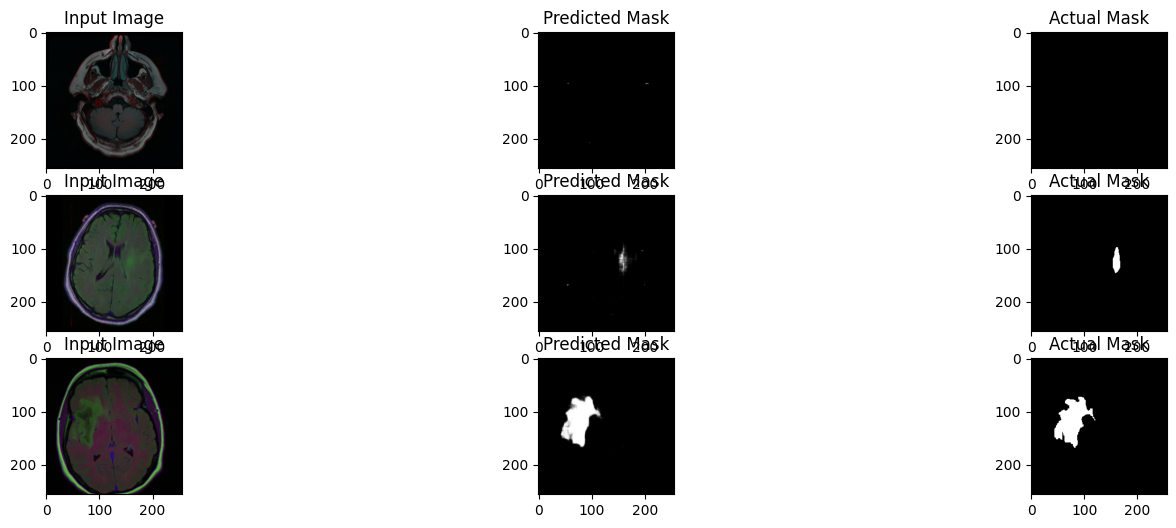

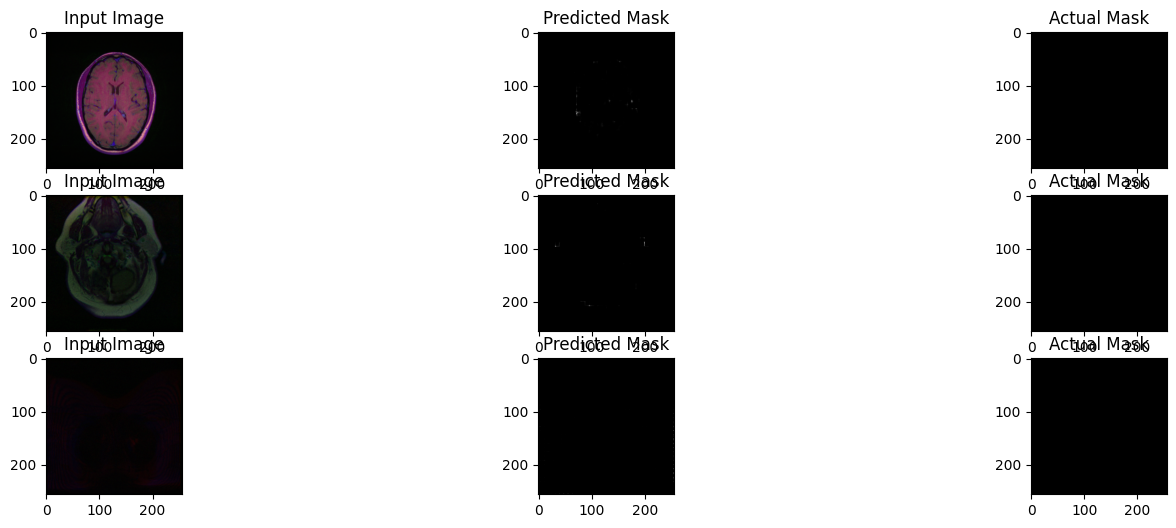

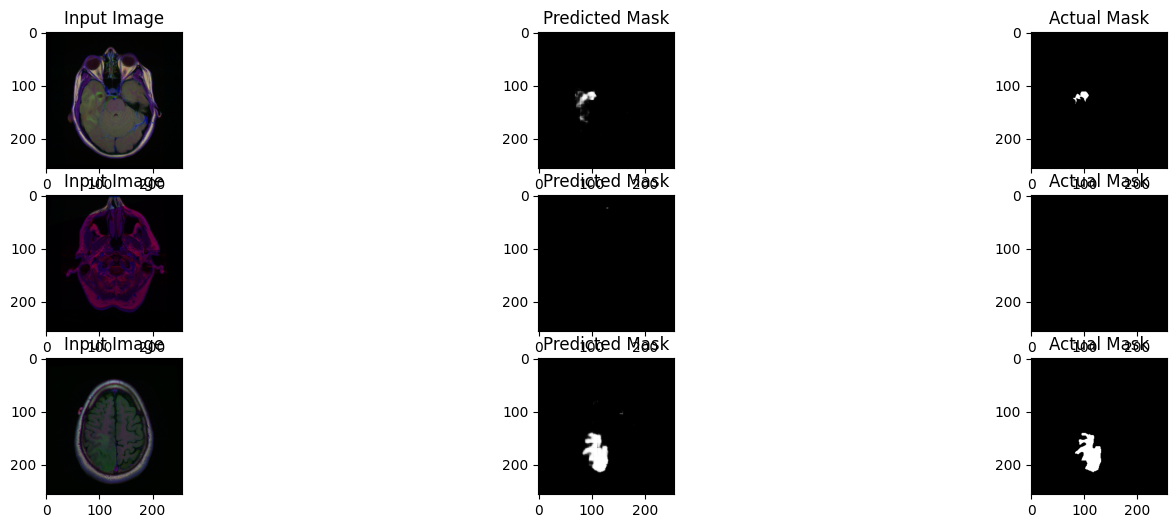

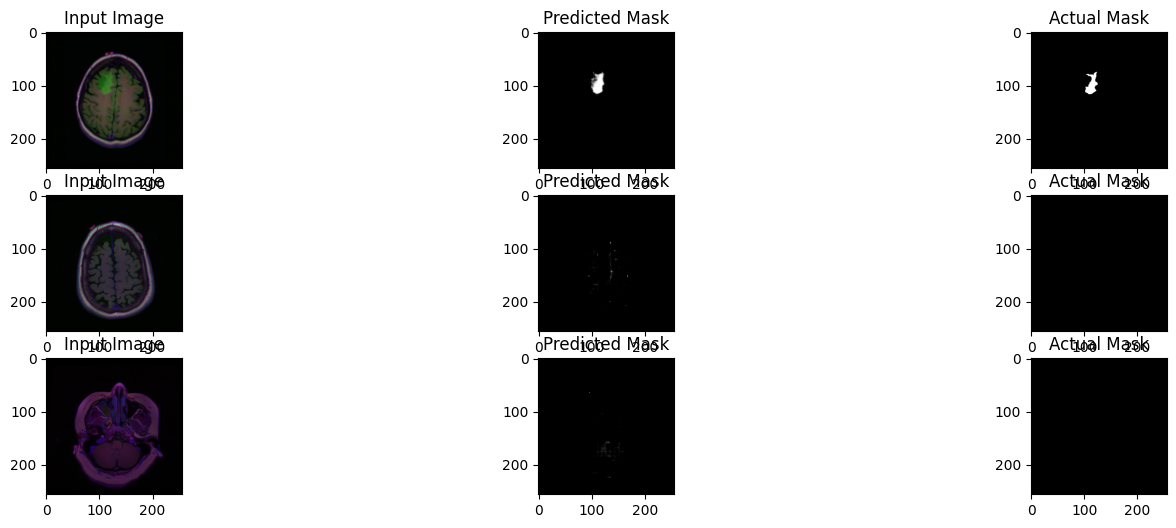

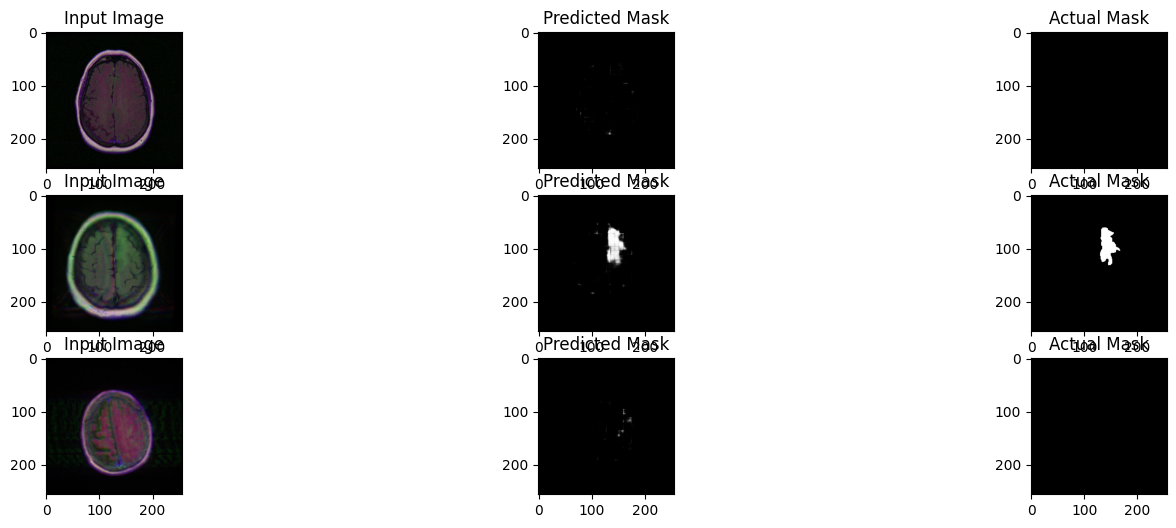

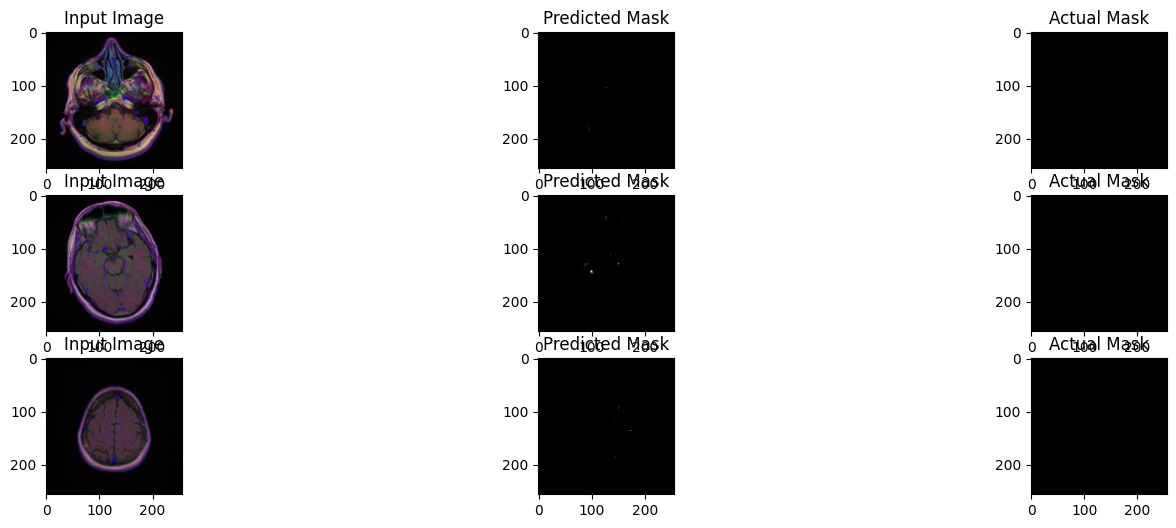

In [13]:
from tqdm import tqdm
# Loss function and optimizer
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=3e-4)

# Training loop
def train(model, dataloader, dev_dataloader, criterion, optimizer, num_epochs=10, patience=15):
    model.train()
    best_dev_loss = np.inf
    early_stopping_counter = 0
    patience = patience
    for epoch in tqdm(range(num_epochs)):
        running_loss = 0.0
        for images, masks in dataloader:
            # Move tensors to the appropriate device
            images = images.float().to(device)
            masks = masks.float().to(device)

            # Zero the parameter gradients
            optimizer.zero_grad()

            # Forward pass
            outputs = model(images)
            loss = criterion(outputs, masks)

            # Backward pass and optimize
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * images.size(0)

        epoch_loss = running_loss / len(dataloader.dataset)
        print(f'Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss:.4f}')

        model.eval()
        dev_loss = 0.0
        with torch.no_grad():
            for images, masks in tqdm(dev_dataloader, desc='Evaluating on dev set', unit='batch'):
                images = images.float().to(device)
                masks = masks.float().to(device)

                outputs = model(images)
                loss = criterion(outputs, masks)
                dev_loss += loss.item() * images.size(0)

        dev_loss = dev_loss / len(dev_dataloader.dataset)
        print(f'Dev Loss: {dev_loss:.4f}')
        if (epoch+1) % 10 == 0:
            torch.save(model.state_dict(), f'model_{epoch+1}.pth')

        if dev_loss < best_dev_loss:
            best_dev_loss = dev_loss
            early_stopping_counter = 0
        else:
            early_stopping_counter += 1
            if early_stopping_counter >= patience:
                print(f'Early stopping after {epoch+1} epochs.')
                torch.save(model.state_dict(), 'final_model.pth')
                break

def evaluate(model, dataloader):
    model.eval()
    with torch.no_grad():
        counter = 0
        for images, masks in dataloader:
            if counter > 10:
                break
            counter += 1
            # Move tensors to the appropriate device
            images = images.float().to(device)
            masks = masks.float().to(device)

            # Forward pass
            outputs = model(images)

            # Plot the results for visualization
            plt.figure(figsize=(18, 6))
            for i in range(min(len(images), 3)):
                plt.subplot(3, 3, i*3 + 1)
                plt.imshow(images[i].cpu().numpy().transpose(1, 2, 0))
                plt.title('Input Image')

                plt.subplot(3, 3, i*3 + 2)
                plt.imshow(outputs[i].cpu().numpy().squeeze(), cmap='gray')
                plt.title('Predicted Mask')

                plt.subplot(3, 3, i*3 + 3)
                plt.imshow(masks[i].cpu().numpy().squeeze(), cmap='gray')
                plt.title('Actual Mask')

            plt.show()


image_paths = train_df['Image'].values.tolist()
mask_paths = train_df['Mask'].values.tolist()

dev_paths = val_df['Image'].values.tolist()
dev_mask_paths = val_df['Mask'].values.tolist()
dataset = SegmentationDataset(image_paths, mask_paths, transform=transform)
dev_dataset = SegmentationDataset(dev_paths, dev_mask_paths, transform=transform)

dataloader = DataLoader(dataset, batch_size=32, shuffle=True)
dev_dataloader = DataLoader(dev_dataset, batch_size=32, shuffle=False)
# Training
train(model, dataloader, dev_dataloader, criterion, optimizer, num_epochs=500)

# Evaluation
evaluate(model, dataloader)


### Evaluating the performance

This section evaluates our model's segmentation performance using two common metrics: Intersection over Union (IoU) and Dice coefficient (Dice). Both metrics quantify the overlap between predicted and ground truth segmentation masks.

IoU focuses on the ratio of correctly classified pixels, while Dice emphasizes the balance between true positives and both false positives and negatives. We'll calculate these scores to assess the model's segmentation accuracy.

In [14]:
import torch

def iou_score(y_true, y_pred, smooth=1e-6):
    intersection = torch.sum(y_true * y_pred)
    union = torch.sum(y_true) + torch.sum(y_pred) - intersection
    iou = (intersection + smooth) / (union + smooth)
    
    return iou

def dice_score(y_true, y_pred, smooth=1e-6):
    intersection = torch.sum(y_true * y_pred)
    dice = (2. * intersection + smooth) / (torch.sum(y_true) + torch.sum(y_pred) + smooth)
    #print(dice)
    return dice


In [15]:
def eval_model(model, test_loader, device):
    model.eval()
    ious = []
    dices = []

    with torch.no_grad():
        for images, masks in test_loader:
            images = images.float().to(device)
            masks = masks.float().to(device)
            outputs = model(images)
            
            outputs[outputs < .5] = 0
            outputs[outputs > .5] = 1

            iou_score_val = iou_score(outputs, masks)
            dice_score_val = dice_score(outputs, masks)

            ious.append(iou_score_val)
            dices.append(dice_score_val)

    mean_iou = sum(ious) / len(ious)
    mean_dice = sum(dices) / len(dices)

    return mean_iou, mean_dice

In [16]:
test_dataset = SegmentationDataset(test_df[test_df['Diagnosis'] == 1]['Image'].values.tolist(), test_df[test_df['Diagnosis'] == 1]['Mask'].values.tolist(), transform=transform)
test_dataloader = DataLoader(test_dataset, batch_size=64, shuffle=False)
eval_model(model, test_dataloader, device)

(tensor(0.7890, device='cuda:0'), tensor(0.8818, device='cuda:0'))

In [17]:
torch.save(model.state_dict(), 'baseline_ckpt.pth')

In [18]:
model.load_state_dict(torch.load('baseline_ckpt.pth'))

<ipython-input-18-416895099476>:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('baseline_ckpt.pth'))


<All keys matched successfully>